In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import glob
PROJECT_LOCATION = "/content/drive/MyDrive/playground/medical_image_analysis/Homework3"
os.chdir(PROJECT_LOCATION)

In [ ]:
DATA_LOCATION = "./dataset"

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

plt.ion()   # interactive mode

In [ ]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight

In [ ]:
# data loader part

data_transforms = {
  'train': transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
  'val': transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
  'test': transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_LOCATION, x), data_transforms[x]) for x in ['train', 'val', 'test']}

weights = {x: make_weights_for_balanced_classes(image_datasets[x], 3) for x in ['train', 'val', 'test']}

# sampler part handles the class imbalance, shuffle = True
sampler = {x: torch.utils.data.sampler.WeightedRandomSampler(weights[x], len(weights[x])) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle = True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



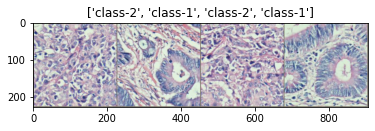

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
model_conv = models.alexnet(pretrained = True)

for param in model_conv.parameters():
  param.requires_grad = False




In [ ]:
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, 3)
model_conv = model_conv.to(device)



criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7088 Acc: 0.7386
val Loss: 0.6730 Acc: 0.7273

Epoch 1/24
----------
train Loss: 0.4488 Acc: 0.8627
val Loss: 1.1326 Acc: 0.6667

Epoch 2/24
----------
train Loss: 0.4115 Acc: 0.8889
val Loss: 1.0669 Acc: 0.7273

Epoch 3/24
----------
train Loss: 0.3377 Acc: 0.8824
val Loss: 1.7166 Acc: 0.6364

Epoch 4/24
----------
train Loss: 0.2816 Acc: 0.9216
val Loss: 1.6401 Acc: 0.7273

Epoch 5/24
----------
train Loss: 0.3515 Acc: 0.8824
val Loss: 1.7651 Acc: 0.5455

Epoch 6/24
----------
train Loss: 0.2899 Acc: 0.9216
val Loss: 1.6114 Acc: 0.5758

Epoch 7/24
----------
train Loss: 0.1721 Acc: 0.9477
val Loss: 1.3817 Acc: 0.6667

Epoch 8/24
----------
train Loss: 0.1411 Acc: 0.9542
val Loss: 1.3068 Acc: 0.6667

Epoch 9/24
----------
train Loss: 0.1082 Acc: 0.9542
val Loss: 1.3945 Acc: 0.6970

Epoch 10/24
----------
train Loss: 0.1697 Acc: 0.9346
val Loss: 1.2599 Acc: 0.6667

Epoch 11/24
----------
train Loss: 0.1404 Acc: 0.9477
val Loss: 1.3687 Acc: 0.6970

Ep

In [ ]:
# Accuracy Calcution

confusion_matrix = torch.zeros(3, 3)
with torch.no_grad():
  for x in ['train', 'test', 'val']:
    for i, (inputs, classes) in enumerate(dataloaders[x]):
      inputs = inputs.to(device)
      classes = classes.to(device)
      outputs = model_conv(inputs)
      _, preds = torch.max(outputs, 1)
      for t, p in zip(classes.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
      
    print(x)
    print(confusion_matrix)
    print(confusion_matrix.diag()/(confusion_matrix.sum(0) + confusion_matrix.sum(1) - confusion_matrix.diag()))
    print(confusion_matrix.diag().sum() / confusion_matrix.sum())

train
tensor([[42.,  7.,  0.],
        [ 1., 75.,  0.],
        [ 1., 10., 17.]])
tensor([0.8235, 0.8065, 0.6071])
tensor(0.8758)
test
tensor([[ 84.,  13.,   0.],
        [  1., 129.,   3.],
        [  3.,  18.,  46.]])
tensor([0.8317, 0.7866, 0.6571])
tensor(0.8721)
val
tensor([[ 91.,  17.,   0.],
        [  1., 140.,   4.],
        [  5.,  20.,  52.]])
tensor([0.7982, 0.7692, 0.6420])
tensor(0.8576)
